In [1]:
edvoldata = read.csv("EGDailyVolume.csv",header=T)
## Process Dates
year = edvoldata$Year
month = edvoldata$Month
day = edvoldata$Day
datemat = cbind(as.character(day),as.character(month),as.character(year))
paste.dates = function(date){
    day = date[1]; month=date[2]; year = date[3]
    return(paste(day,month,year,sep="/"))
 }
dates = apply(datemat,1,paste.dates)
dates = as.Date(dates, format="%d/%m/%Y")
edvoldata = cbind(dates,edvoldata)
attach(edvoldata)
Volume.tr = sqrt(Volume+3/8)

The following object is masked _by_ .GlobalEnv:

    dates



In [2]:
## Model Trend + Monthly Seasonality
library(mgcv)
time.pts = c(1:length(Volume))
time.pts = c(time.pts - min(time.pts))/max(time.pts)
month = as.factor(format(dates,"%b"))
week = as.factor(weekdays(dates))

#we use gam to fit our model
gam.fit.seastr = gam(Volume.tr~s(time.pts)+month+week)
vol.fit.gam.seastr = fitted(gam.fit.seastr)
resid.process = Volume.tr-vol.fit.gam.seastr

Warning message:
"package 'mgcv' was built under R version 3.6.3"Loading required package: nlme
Warning message:
"package 'nlme' was built under R version 3.6.3"This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.


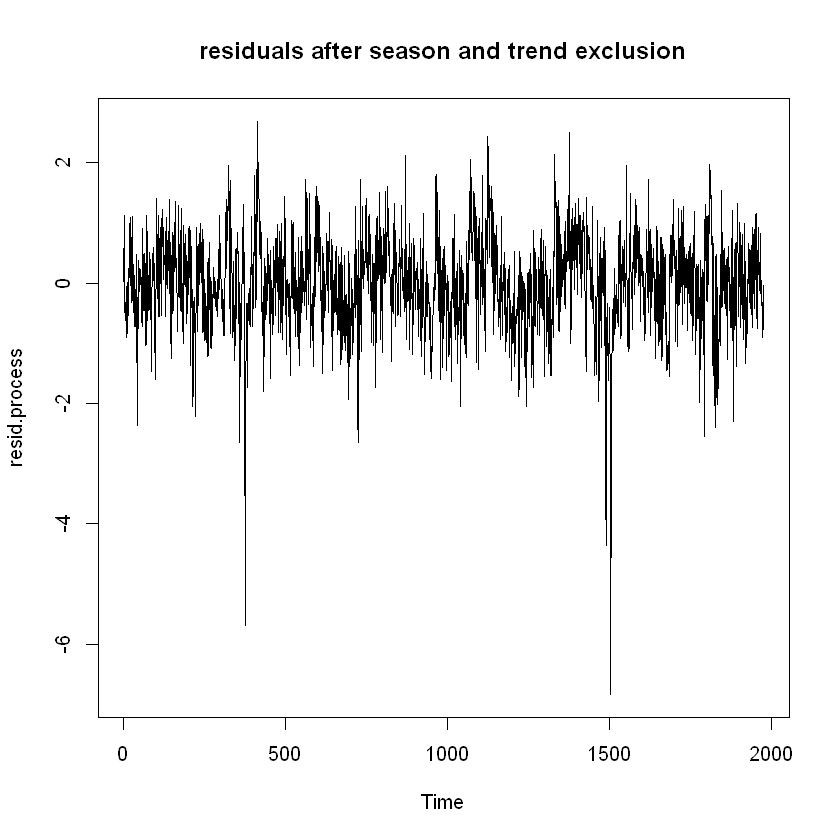

In [3]:
plot.ts(resid.process, main='residuals after season and trend exclusion')

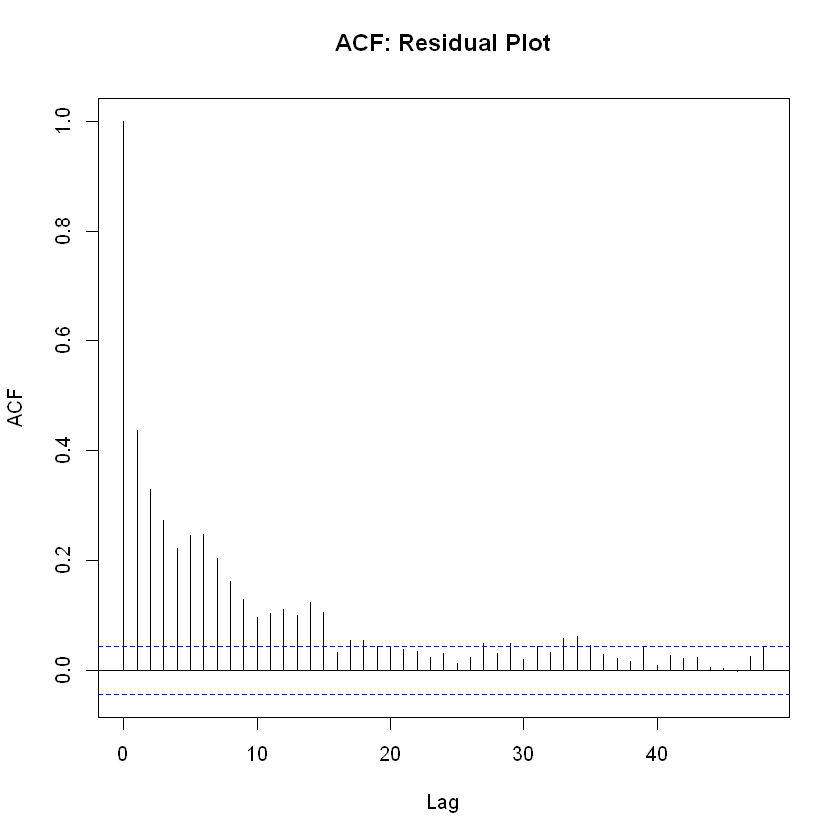

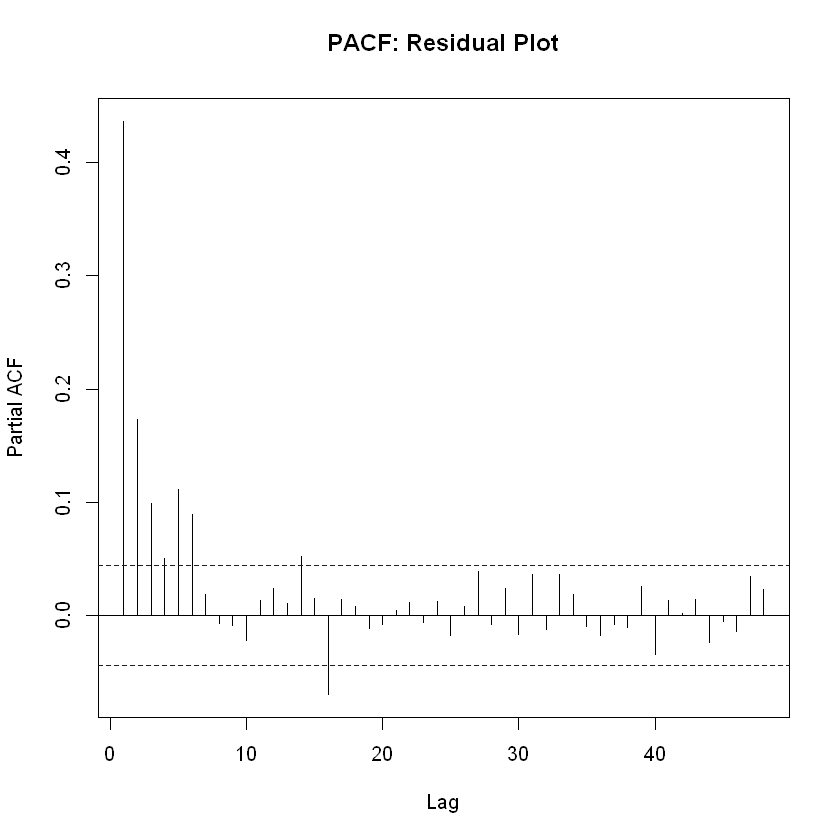

In [4]:
################################################################
acf(resid.process,lag.max=12*4,main="ACF: Residual Plot")
pacf(resid.process,lag.max=12*4,main="PACF: Residual Plot")

In [5]:
###############################################################
library(TSA)
###### Fit an AR(p) process for for p<= order.max ####
mod = ar(resid.process,order.max=20)
# What is the selected order?
print(mod$order)


Attaching package: 'TSA'

The following objects are masked from 'package:stats':

    acf, arima

The following object is masked from 'package:utils':

    tar



[1] 6


In [6]:
# find the list of arguments provided by AR fit
summary(mod)

             Length Class  Mode     
order           1   -none- numeric  
ar              6   -none- numeric  
var.pred        1   -none- numeric  
x.mean          1   -none- numeric  
aic            21   -none- numeric  
n.used          1   -none- numeric  
n.obs           1   -none- numeric  
order.max       1   -none- numeric  
partialacf     20   -none- numeric  
resid        1977   -none- numeric  
method          1   -none- character
series          1   -none- character
frequency       1   -none- numeric  
call            3   -none- call     
asy.var.coef   36   -none- numeric  

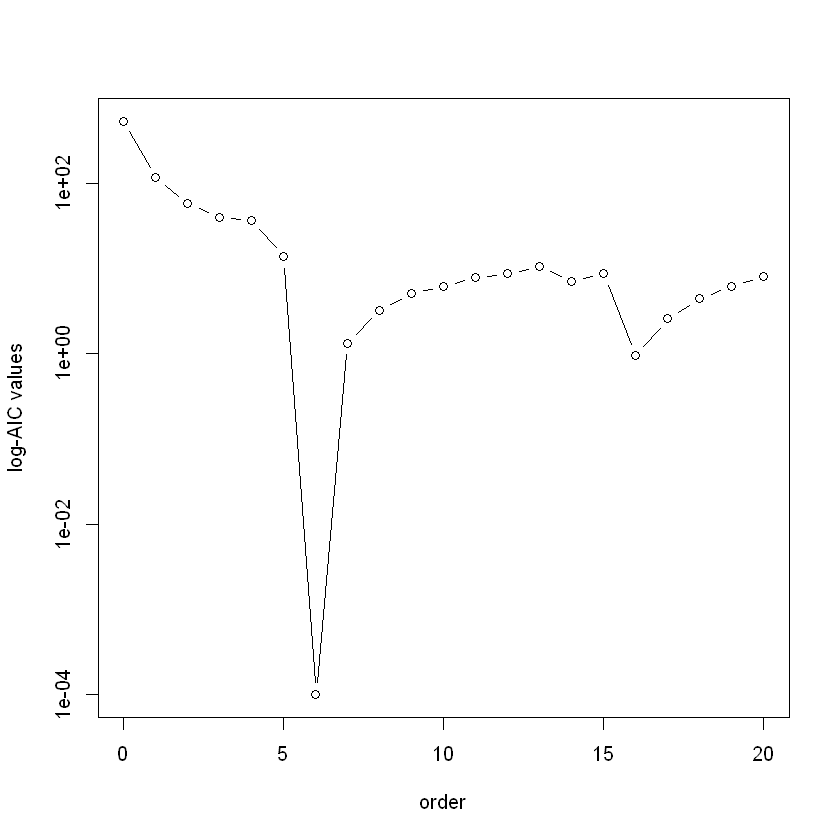

In [7]:
# plot aic values
# On non-log scale it is difficult to detect the minimum.
plot(c(0:20),mod$aic+.0001, type="b",log="y",xlab="order",ylab="log-AIC values")

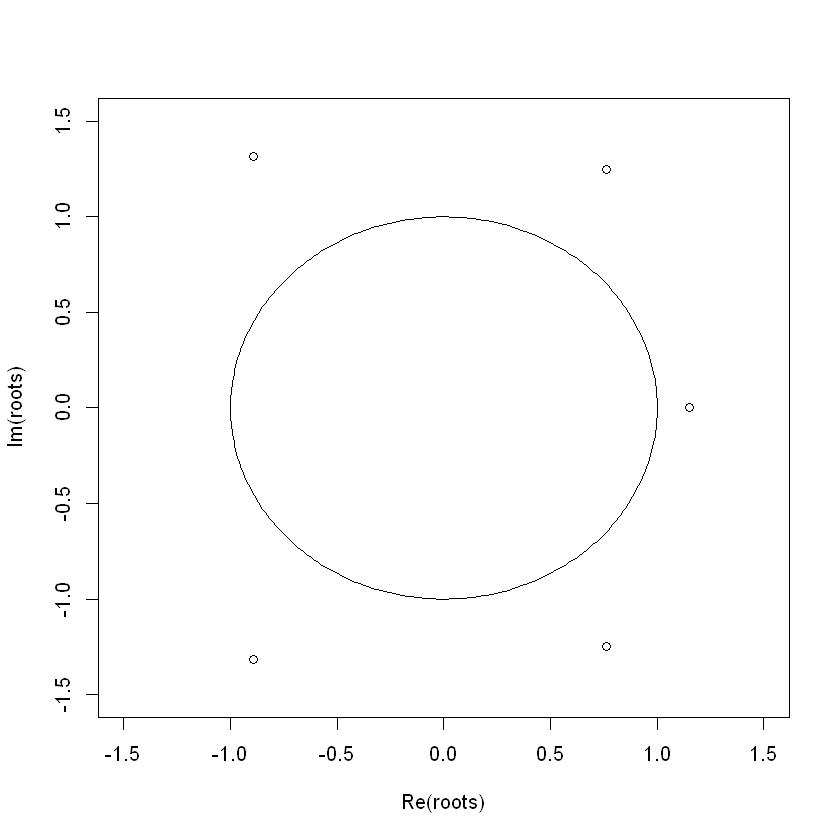

In [8]:
# Are the roots of fitted AR within the unit circle?
# extract roots from the model output
roots = polyroot(c(1,(-mod$ar)))
# adjust the x and y -axis limits to include the full circle
plot(roots,xlim=c(-1.5,1.5),ylim=c(-1.5,1.5))
# draw a unit root circle
lines(complex(arg = seq(0,2*pi,len=300)))

In [9]:
mod$order+1

[1] 7

In [10]:
length(mod$resid)

[1] 1977

In [11]:
# residuals analysis: Note first 6 residuals will <NA> as due to order 6 for AR(p)
resids = mod$resid[(mod$order+1): length(mod$resid)]

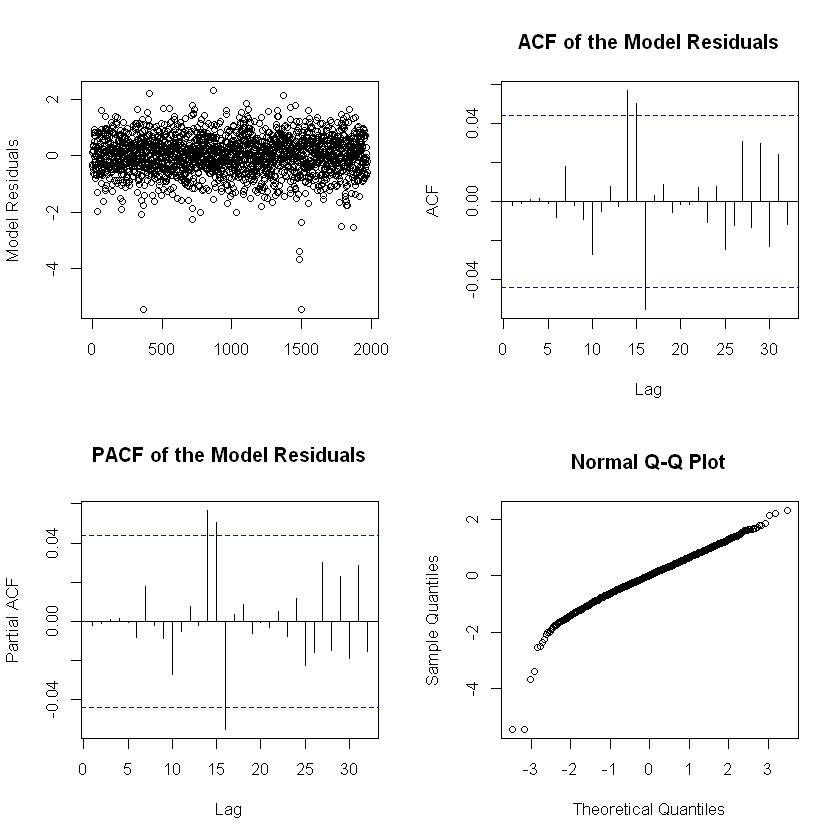

In [12]:
par(mfrow=c(2,2))
plot(resids,xlab="",ylab="Model Residuals")
acf(resids,main='ACF of the Model Residuals')
pacf(resids,main='PACF of the Model Residuals')
qqnorm(resids)

We can conisder residuals to be fairly white noise.  Note: for ACF take them to be too small

In [13]:
###### Fit an ARMA(p,q) for some values of p=6 and q=1 #####
modarma = arima(resid.process, order = c(6,0,1),method = "ML")

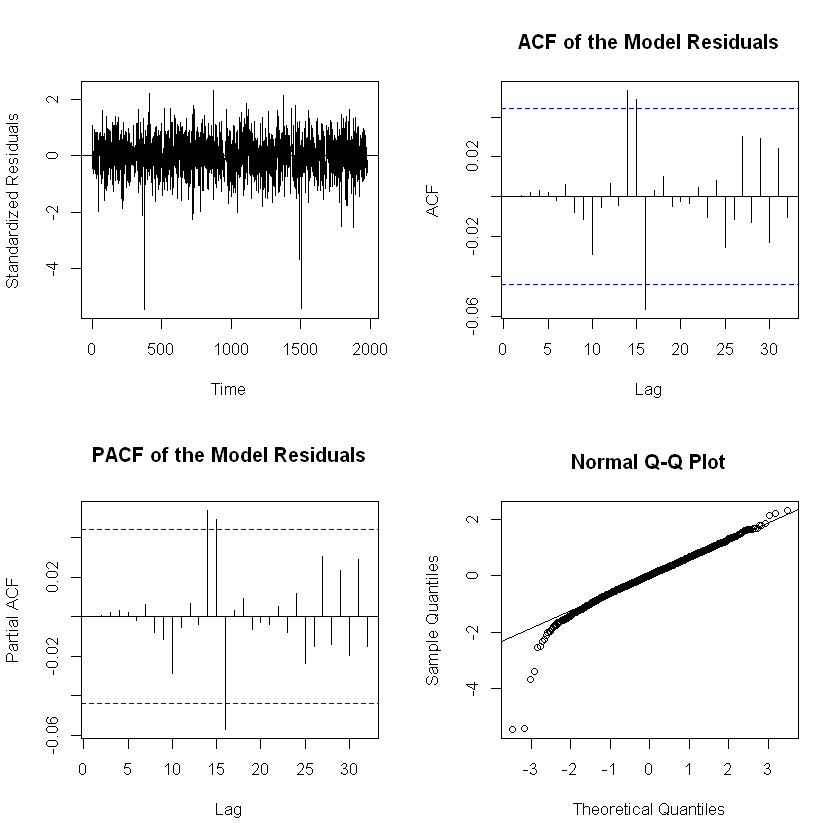

In [14]:
#residual analysis for ARMA model
par (mfrow=c(2,2))
plot(resid(modarma), ylab='Standardized Residuals')
abline(h=0)
acf(as.vector(resid(modarma)),main= 'ACF of the Model Residuals')
pacf(as.vector(resid(modarma)),main='PACF of the Model Residuals')
qqnorm(resid(modarma))
qqline(resid(modarma))

In [15]:
## Order selection -- AIC 
n = length(resid.process)
norder = 6
p = c(1:norder)-1; q = c(1:norder)-1
aic = matrix(0,norder,norder)
for(i in 1:norder){
   for(j in 1:norder){
    modij = arima(resid.process,order = c(p[i],0,q[j]), method='ML')
    aic[i,j] = modij$aic-2*(p[i]+q[j]+1)+2*(p[i]+q[j]+1)*n/(n-p[i]-q[j]-2)
   }  
 }

Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"Warning message in log(s2):
"NaNs produced"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence

Warning message in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg, :
"possible convergence problem: optim gave code = 1"

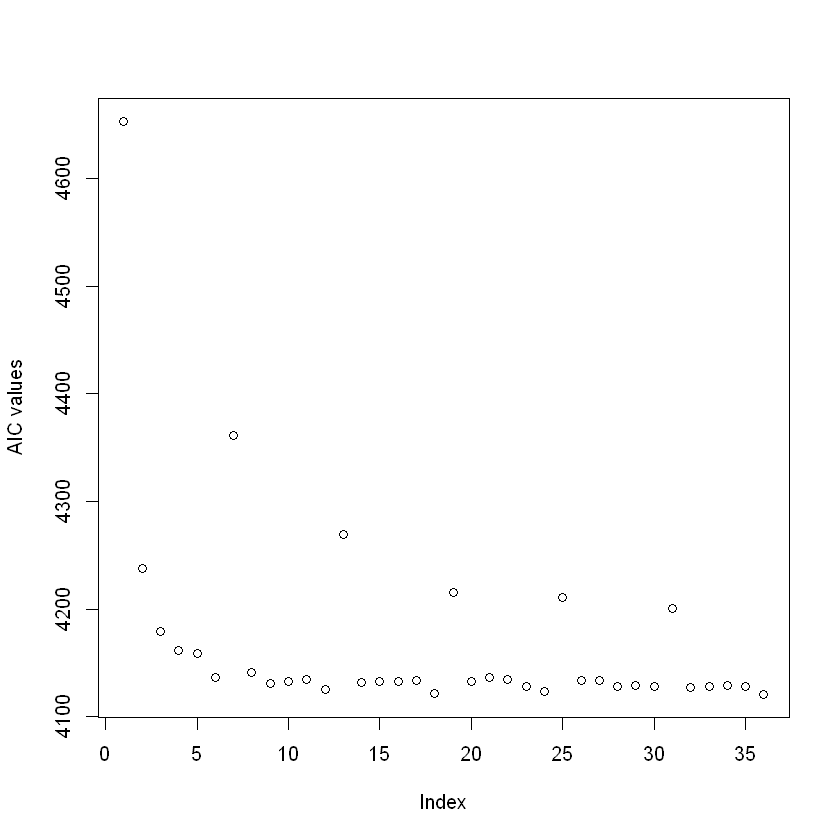

In [16]:
aicv = as.vector(aic)  
plot(aicv,ylab="AIC values")
indexp = rep(c(1:norder),norder)
indexq = rep(c(1:norder),each=norder)
indexaic = which(aicv == min(aicv))
porder = indexp[indexaic]-1
qorder = indexq[indexaic]-1
final_model = arima(resid.process,order = c(porder,0,qorder), method='ML')

In [17]:
print(porder)
print(qorder)

[1] 5
[1] 5


ARMA 5,5 is selected

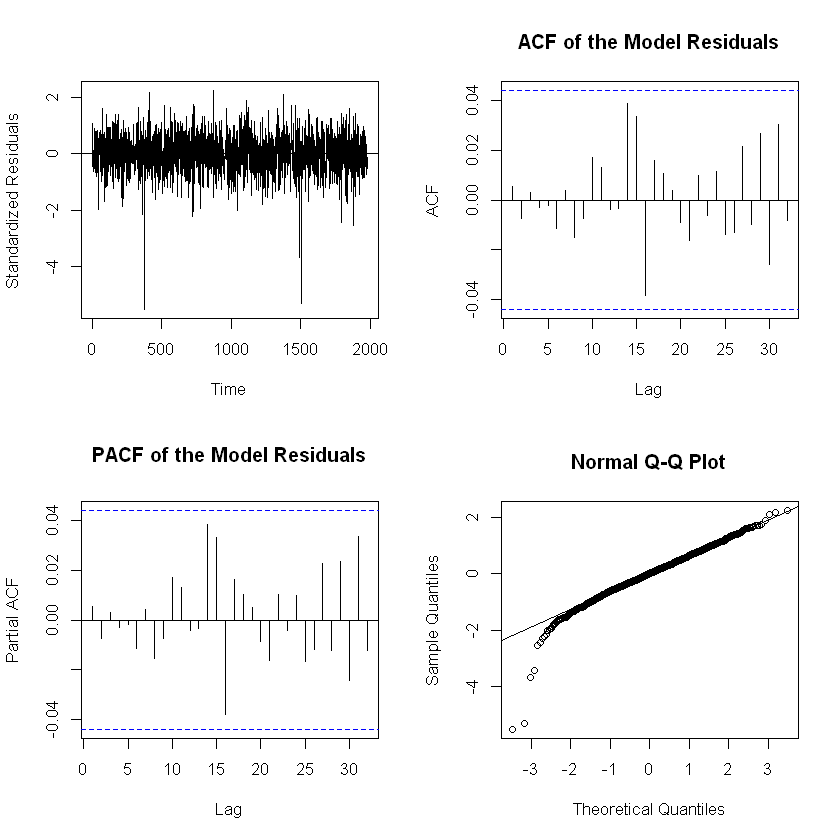

In [18]:
par (mfrow=c(2,2))
plot(resid(final_model), ylab='Standardized Residuals')
abline(h=0)
acf(as.vector(resid(final_model)),main= 'ACF of the Model Residuals')
pacf(as.vector(resid(final_model)),main='PACF of the Model Residuals')
qqnorm(resid(final_model))
qqline(resid(final_model))

These results for ARMA(5,5) are almost similar to model ARMA(6,1). Hence by parsimony principle we can choose ARMA(6,1).

In [19]:
#### Test for Independence for final model
Box.test(final_model$resid, lag = (porder+qorder+1), fitdf = (porder+qorder))
Box.test(modarma$resid, lag = (porder+qorder+1), fitdf = (porder+qorder))


	Box-Pierce test

data:  final_model$resid
X-squared = 1.9961, df = 1, p-value = 0.1577



	Box-Pierce test

data:  modarma$resid
X-squared = 2.2056, df = 1, p-value = 0.1375


Both say that the process has autocorrelation as 0 uptill specified lag.